In [6]:

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn

import seaborn as sns

# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
from IPython.core.display import HTML
import seaborn as sns
import re
%matplotlib inline

css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

## Data Gathering and EDA

Importing the data into a **pandas Dataframe**

In [7]:
titles = pd.DataFrame.from_csv('movie_metadata.csv', index_col=None)

In [8]:
titles.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')

In [9]:
titles=titles.set_index('movie_title')

Creating a ratio field for profit percentage

In [10]:
titles['ratio']=titles.gross/titles.budget

In [11]:
titles=titles=titles.dropna(axis=0, subset=['imdb_score','gross', 'budget', 'ratio', 'director_facebook_likes' , 'content_rating' , 'title_year' , 'movie_facebook_likes' ])

Checking the distribution of **movie ratings**.  
Low frequency ratings are removed later to improve prediction accuracy.


In [12]:
titles.content_rating.value_counts()

R            1737
PG-13        1331
PG            576
G              91
Not Rated      42
Unrated        24
Approved       17
X              10
NC-17           6
Passed          3
M               2
GP              1
Name: content_rating, dtype: int64

**Analyzing `imdb` score disctribution**

In [13]:
((titles.imdb_score//1)).value_counts()

6.0    1459
7.0    1091
5.0     769
4.0     217
8.0     211
3.0      64
2.0      22
9.0       4
1.0       3
Name: imdb_score, dtype: int64

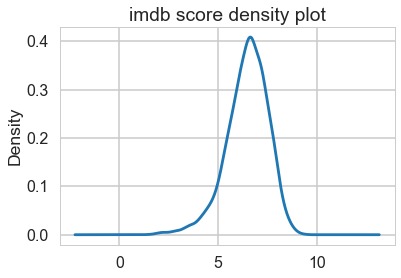

In [14]:
titles.imdb_score.plot.kde(title='imdb score density plot' )

In [15]:
titles.genres=titles.genres.str.replace("\|.*","")


**Analyzing Genre Distribution of the movies**

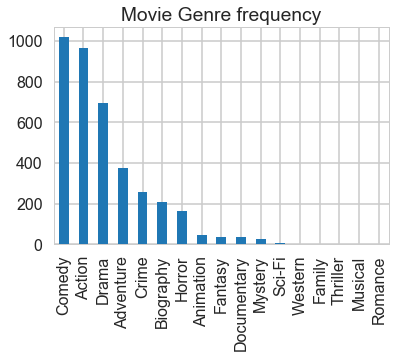

In [16]:
titles.genres.value_counts().plot(kind = 'bar', title='Movie Genre frequency')

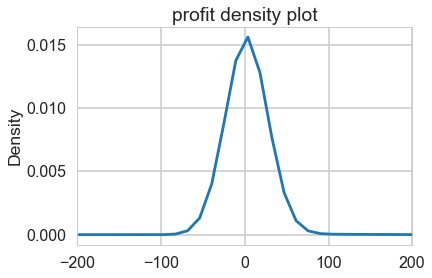

In [17]:
titles.ratio.plot.kde(xlim=[-200,200] , title='profit density plot')

** looking for outliers in profit ratio. To improve efficiency of the model **


In [18]:
(titles.ratio//100).value_counts()

0.0     3823
1.0        9
2.0        2
3.0        2
71.0       1
4.0        1
27.0       1
23.0       1
Name: ratio, dtype: int64

**removing movies with a very high profit ratio (>200x) for which are mostly low budget movies**

In [19]:
titles=titles.drop(titles[(titles.ratio>200)].index)

In [20]:
titles.ratio.mean() , titles.ratio.std() 


(2.7023612667579786, 8.60812467633687)

## Profit distribution
**Majority of movies make a loss**


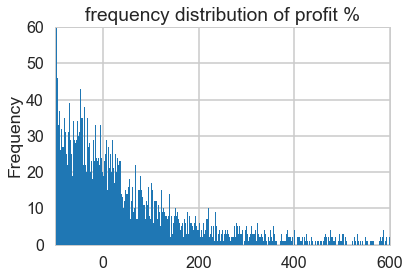

In [21]:
((titles.ratio -1 )*100).plot.hist(xlim=[-100,600],ylim=[0,60],bins=10000,title="frequency distribution of profit %")

In [22]:
titles.ratio.mean() , titles.ratio.std() , titles.ratio.median() 

(2.7023612667579786, 8.60812467633687, 1.081657044736842)

**Defining the criterion of a classifying a movie as profit making. 
Choosing a value well above the median:: `20%` profit**


In [23]:
titles['profit_making']= (titles.ratio > 1.2)

In [24]:
titles.profit_making.value_counts()

False    2059
True     1773
Name: profit_making, dtype: int64

##  Sending budget and likes through normalizer


In [25]:
def normalize(array1, name):
    print ("normalizing "+name);
    array=array1
    array=array/array.std()
    array=array-array.mean()
    return(array);

In [26]:
for column in ['budget','movie_facebook_likes','cast_total_facebook_likes','director_facebook_likes','actor_1_facebook_likes','actor_2_facebook_likes','duration','num_voted_users', 'num_user_for_reviews', 'gross']:
    if np.issubdtype(titles[column].dtype, np.number):
        print (column + ": true")
        titles[column]=normalize(array1=titles[column],name=column)
    else:
        print (column + ":false")

budget: true
normalizing budget
movie_facebook_likes: true
normalizing movie_facebook_likes
cast_total_facebook_likes: true
normalizing cast_total_facebook_likes
director_facebook_likes: true
normalizing director_facebook_likes
actor_1_facebook_likes: true
normalizing actor_1_facebook_likes
actor_2_facebook_likes: true
normalizing actor_2_facebook_likes
duration: true
normalizing duration
num_voted_users: true
normalizing num_voted_users
num_user_for_reviews: true
normalizing num_user_for_reviews
gross: true
normalizing gross


In [27]:
titles2 = pd.DataFrame.from_csv('movie_metadata.csv', index_col=None)

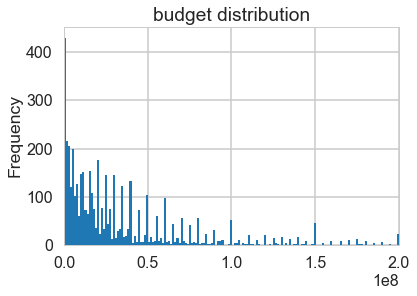

In [28]:
(titles2.budget).plot.hist(bins=10000,xlim=[0,200e6],title="budget distribution")


** Vital budget statistics in $ million** 

In [29]:
titles2.budget.mean()/1e6 , titles2.budget.std()/1e6 , titles2.budget.median()/1e6


(39.75262043638761, 206.11489844868385, 20.0)

In [30]:
((titles2.budget//10000000)).value_counts().sort_index()


0.0       1457
1.0        803
2.0        579
3.0        406
4.0        260
5.0        217
6.0        179
7.0        122
8.0         93
9.0         60
10.0        71
11.0        32
12.0        38
13.0        34
14.0        27
15.0        47
16.0        15
17.0        24
18.0        11
19.0         7
20.0        28
21.0         5
22.0         7
23.0         2
24.0         1
25.0         9
26.0         2
30.0         2
39.0         1
40.0         1
55.0         1
60.0         1
70.0         2
100.0        1
110.0        1
212.0        1
240.0        1
250.0        1
420.0        1
1221.0       1
Name: budget, dtype: int64

#### Splitting titles into low budget and high budget movies

In [31]:
titles_highb = titles[(titles.budget > -.114)]

In [32]:
titles_lowb = titles[(titles.budget <= -.114)]

In [33]:
len(titles_highb)

2052

In [34]:
len(titles_lowb)

1780

In [35]:
titles_highb.profit_making.mean()

0.40692007797270957

In [36]:
titles_lowb.profit_making.mean()

0.52696629213483148

In [37]:
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle


In [38]:
titles_highb=shuffle(titles_highb)

In [39]:
titles_highb=titles_highb[['imdb_score','gross', 'budget', 'ratio', 'director_facebook_likes' , 'content_rating' , 'title_year' , 'movie_facebook_likes' ,'actor_1_facebook_likes','actor_2_facebook_likes','actor_3_facebook_likes']]

In [40]:
titles_highb=titles_highb.dropna(axis=0, subset = ['actor_1_facebook_likes','actor_2_facebook_likes','actor_3_facebook_likes'])

In [41]:
titles_highb_train=titles_highb[:1500]
titles_highb_test=titles_highb[1500:]

In [42]:
titles_cat=titles

In [43]:
from pandas import get_dummies

In [44]:
type (titles_cat)

pandas.core.frame.DataFrame

#### **Converting non quantitative data items (Genres and Ratings) into features**

In [45]:
titles_cat=pd.get_dummies(titles_cat , columns=["genres"])

In [46]:
titles_cat.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'actor_1_name', 'num_voted_users',
       'cast_total_facebook_likes', 'actor_3_name', 'facenumber_in_poster',
       'plot_keywords', 'movie_imdb_link', 'num_user_for_reviews', 'language',
       'country', 'content_rating', 'budget', 'title_year',
       'actor_2_facebook_likes', 'imdb_score', 'aspect_ratio',
       'movie_facebook_likes', 'ratio', 'profit_making', 'genres_Action',
       'genres_Adventure', 'genres_Animation', 'genres_Biography',
       'genres_Comedy', 'genres_Crime', 'genres_Documentary', 'genres_Drama',
       'genres_Family', 'genres_Fantasy', 'genres_Horror', 'genres_Musical',
       'genres_Mystery', 'genres_Romance', 'genres_Sci-Fi', 'genres_Thriller',
       'genres_Western'],
      dtype='object')

In [47]:
titles_cat.content_rating.value_counts()

R            1730
PG-13        1331
PG            576
G              91
Not Rated      42
Unrated        23
Approved       17
X              10
NC-17           6
Passed          3
M               2
GP              1
Name: content_rating, dtype: int64

** Removing low frequency ratings instances **

In [48]:
titles_cat=titles_cat.drop(titles_cat[titles_cat.content_rating.str.match("NC-17|Passed|M|GP")].index)

In [49]:
titles_cat=pd.get_dummies(titles_cat , columns=["content_rating"])

In [50]:
titles_cat_highb = titles_cat[(titles_cat.budget > -.114)]

In [51]:
titles_cat_lowb = titles_cat[(titles_cat.budget <= -.114)]

In [52]:
len(titles_cat_highb)

2051

In [53]:
len(titles_cat_lowb)

1769

In [54]:
titles_cat_highb.profit_making.mean()

0.40711847879083374

In [55]:
titles_cat_lowb.profit_making.mean()

0.52572074618428488

In [56]:
titles_cat_highb=shuffle(titles_cat_highb)

#### Looks like financial data of foreign movies is not reported in USD. Will need to clean up these data points

In [57]:
titles2[(titles2.budget>500e6)].country.value_counts()

Japan          4
South Korea    2
India          2
Hungary        1
Spain          1
China          1
Name: country, dtype: int64

In [58]:
len(titles_cat_highb[titles_cat_highb.country != "USA"])

339

** Removing foreign movies from the Dataset. Maybe add currency conversion in the future**

In [59]:
titles_cat_highb=titles_cat_highb.drop(titles_cat_highb[titles_cat_highb.country != "USA"].index)

In [60]:
titles_cat_ml_highb=titles_cat_highb.select_dtypes(exclude=['object']) 

In [61]:
titles_cat_ml_highb=titles_cat_ml_highb.select_dtypes(exclude=['bool']) 

In [62]:
titles_cat_ml_highb=titles_cat_ml_highb.dropna()

In [63]:
titles_cat_ml_highb=shuffle(titles_cat_ml_highb)

In [64]:
titles_cat_ml_highb.columns

Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
       'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster',
       'num_user_for_reviews', 'budget', 'title_year',
       'actor_2_facebook_likes', 'imdb_score', 'aspect_ratio',
       'movie_facebook_likes', 'ratio', 'genres_Action', 'genres_Adventure',
       'genres_Animation', 'genres_Biography', 'genres_Comedy', 'genres_Crime',
       'genres_Documentary', 'genres_Drama', 'genres_Family', 'genres_Fantasy',
       'genres_Horror', 'genres_Musical', 'genres_Mystery', 'genres_Romance',
       'genres_Sci-Fi', 'genres_Thriller', 'genres_Western',
       'content_rating_Approved', 'content_rating_G',
       'content_rating_Not Rated', 'content_rating_PG', 'content_rating_PG-13',
       'content_rating_R', 'content_rating_Unrated', 'content_rating_X'],
      dtype='object')

In [65]:
titles2 = pd.DataFrame.from_csv('movie_metadata.csv', index_col=None)

In [66]:
titles2=titles2.set_index('movie_title')

In [67]:
titles2['ratio']=titles2.gross/titles2.budget

In [68]:
titles2=titles2.drop(titles2[titles2.country!="USA"].index)

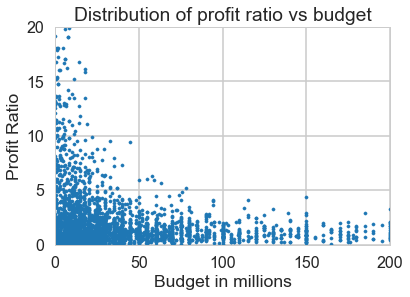

In [69]:
plt.ylim=[0,20]
#plt.xlim=[0,.2e10]
plt.axis([0,200,0,50])
plt.xlabel('Budget in millions')
plt.ylabel('Profit Ratio')
plt.title('Distribution of profit ratio vs budget')
plt.scatter(titles2.budget/(1e6) , titles2.ratio , s=10)
plt.axis([0,200,0,20])

plt.show()

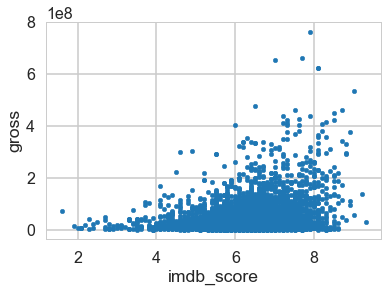

In [70]:
titles2.plot.scatter(x='imdb_score',y='gross')

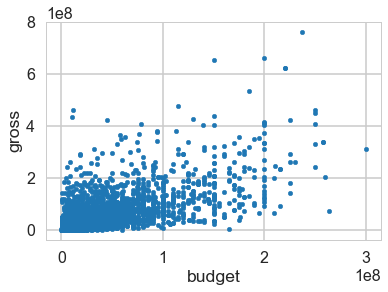

In [71]:
titles2.plot.scatter(x='budget',y='gross')

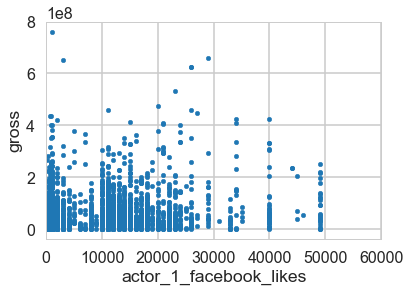

In [72]:
titles2.plot.scatter(x='actor_1_facebook_likes',y='gross', xlim=[0,60000])

## Classification

## `Logistic Regression `

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [74]:
logistic_regression_1= LogisticRegression()

In [75]:
titles_cat_ml_highb=titles_cat_highb.select_dtypes(exclude=['object']) 

In [246]:
#titles2.plot.scatter(x='budget',y='gross')
'''
plt.figure(figsize=(10,10) , dpi= 300)
plt.scatter([titles2[titles2.ratio<=1.2].actor_1_facebook_likes] , [titles2[titles2.ratio<=1.2].director_facebook_likes], color=["red"],s=8)
plt.scatter([titles2[titles2.ratio>1.2].actor_1_facebook_likes] , [titles2[titles2.ratio>1.2].director_facebook_likes], color=["green"], s=8)
plt.axis([0,1000 , 0 ,200])
plt.title("red is loss making \n green profit making")
'''

'\nplt.figure(figsize=(10,10) , dpi= 300)\nplt.scatter([titles2[titles2.ratio<=1.2].actor_1_facebook_likes] , [titles2[titles2.ratio<=1.2].director_facebook_likes], color=["red"],s=8)\nplt.scatter([titles2[titles2.ratio>1.2].actor_1_facebook_likes] , [titles2[titles2.ratio>1.2].director_facebook_likes], color=["green"], s=8)\nplt.axis([0,1000 , 0 ,200])\nplt.title("red is loss making \n green profit making")\n'

In [247]:
'''plt.figure(figsize=(10,10) , dpi= 300)
plt.scatter([titles2[titles2.ratio<=1.2].title_year] , [titles2[titles2.ratio<=1.2].budget], color=["red"],s=5)
plt.scatter([titles2[titles2.ratio>1.2].title_year] , [titles2[titles2.ratio>1.2].budget], color=["green"], s=5)
plt.axis([1960,2015 , 0 ,2e8])
plt.title("red is loss making \n green profit making")
'''

'plt.figure(figsize=(10,10) , dpi= 300)\nplt.scatter([titles2[titles2.ratio<=1.2].title_year] , [titles2[titles2.ratio<=1.2].budget], color=["red"],s=5)\nplt.scatter([titles2[titles2.ratio>1.2].title_year] , [titles2[titles2.ratio>1.2].budget], color=["green"], s=5)\nplt.axis([1960,2015 , 0 ,2e8])\nplt.title("red is loss making \n green profit making")\n'

(array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 6 Text xticklabel objects>)

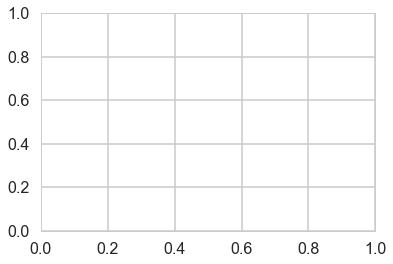

In [78]:
plt.xticks()

[0, 400, 0, 400]

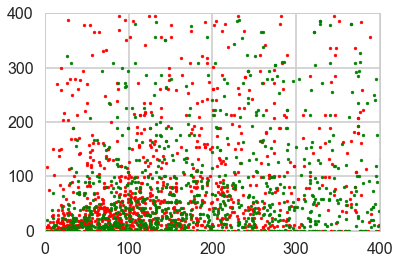

In [79]:
plt.scatter([titles2[titles2.ratio<=1.2].num_user_for_reviews] , [titles2[titles2.ratio<=1.2].director_facebook_likes], color=["red"],s=8)
plt.scatter([titles2[titles2.ratio>1.2].num_user_for_reviews] , [titles2[titles2.ratio>1.2].director_facebook_likes], color=["green"], s=8)
plt.axis([0,400 , 0 ,400])

In [80]:
titles_cat_ml_highb_ratio=titles_cat_ml_highb.ratio

In [81]:
titles_cat_logistic_highb=titles_cat_ml_highb.drop(['ratio'], axis=1)

In [82]:
titles_cat_logistic_highb=titles_cat_logistic_highb.dropna()

In [133]:
titles_cat_logistic_highb=shuffle(titles_cat_logistic_highb)

In [134]:
titles_cat_logistic_highb_train=titles_cat_logistic_highb[:1200]
titles_cat_logistic_highb_test=titles_cat_logistic_highb[1200:]

In [135]:
titles_cat_logistic_highb_train_x=titles_cat_logistic_highb_train.drop(['gross', 'profit_making','movie_facebook_likes','num_voted_users'],axis=1 )

In [136]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    plt.figure(figsize=(10,10) , dpi= 300)
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    plt.yticks(range(len(corr.columns)), corr.columns);

In [137]:
list1=[]
for x in titles_cat_logistic_highb_train.columns:
    if re.match('(content)|(genre)',x):
        list1.append(x)

In [138]:
highb_correlation=titles_cat_logistic_highb_train.drop([ 'movie_facebook_likes','num_voted_users','gross','aspect_ratio'],axis=1 )

In [244]:
highb_correlation=highb_correlation.drop(list1,axis=1)

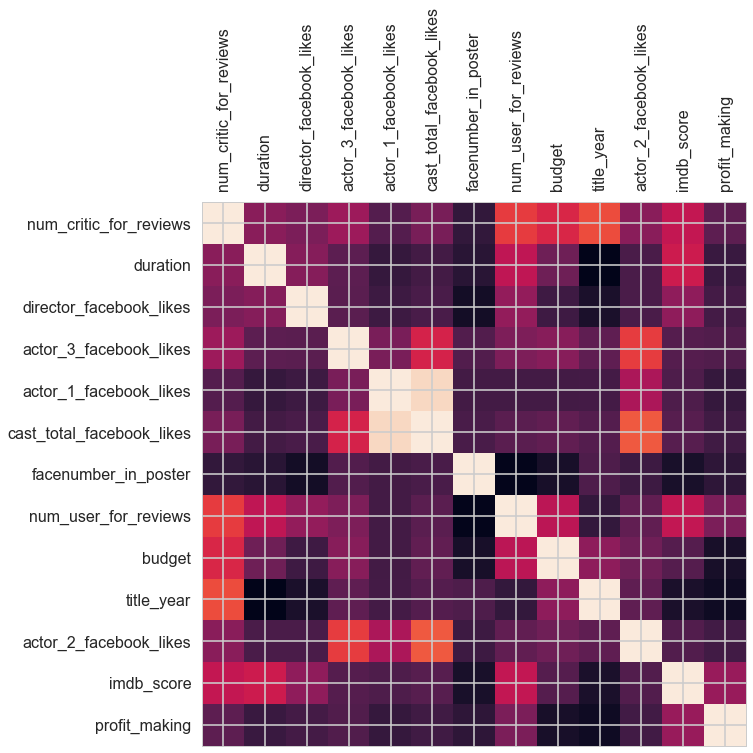

In [245]:
plot_corr(highb_correlation)

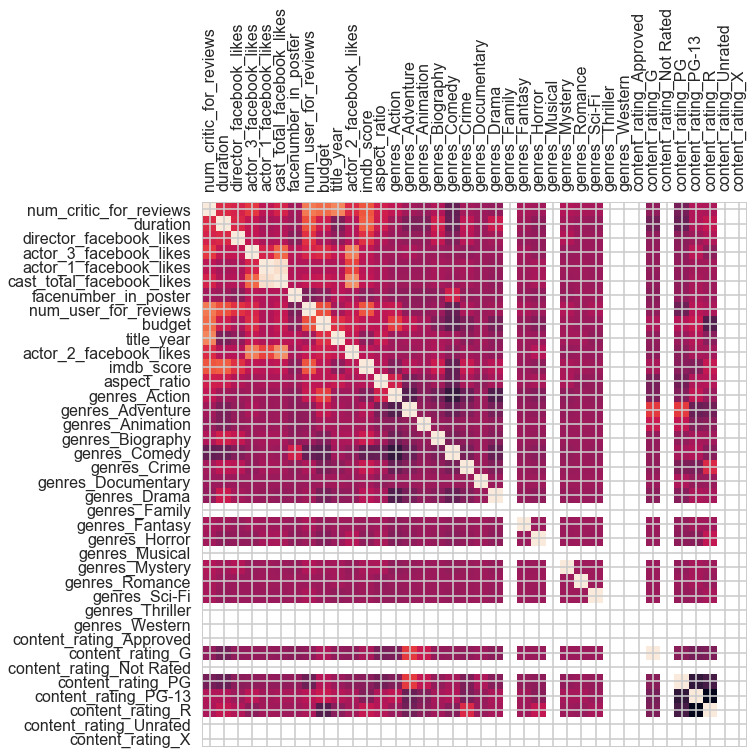

In [141]:
plot_corr(titles_cat_logistic_highb_train_x)

In [142]:
titles_cat_logistic_highb_test_x=titles_cat_logistic_highb_test.drop( ['gross', 'profit_making','movie_facebook_likes','num_voted_users' ],axis=1)

In [143]:
titles_cat_logistic_highb_train_y=pd.DataFrame(titles_cat_logistic_highb_train['profit_making'])

In [144]:
titles_cat_logistic_highb_test_y=pd.DataFrame(titles_cat_logistic_highb_test[ 'profit_making' ])

In [145]:
logistic_regression_1.fit(titles_cat_logistic_highb_train_x,titles_cat_logistic_highb_train_y.profit_making)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [146]:
accuracy_score(logistic_regression_1.predict(titles_cat_logistic_highb_test_x),titles_cat_logistic_highb_test_y.profit_making)

0.68972332015810278

In [147]:
logistic_regression_2=LogisticRegression()

In [148]:
titles_cat_lowb=titles_cat_lowb.drop(titles_cat_lowb[titles_cat_lowb.country!="USA"].index)

In [149]:
titles_cat_ml_lowb=titles_cat_lowb.select_dtypes(exclude=['object']) 

In [150]:
titles_cat_ml_lowb_ratio=titles_cat_ml_lowb.ratio

In [151]:
titles_cat_logistic_lowb=titles_cat_ml_lowb.drop(['ratio'], axis=1)

In [152]:
titles_cat_logistic_lowb=titles_cat_logistic_lowb.dropna()

In [160]:
titles_cat_logistic_lowb=shuffle(titles_cat_logistic_lowb)

In [161]:
titles_cat_logistic_lowb_train=titles_cat_logistic_lowb[:1200]
titles_cat_logistic_lowb_test=titles_cat_logistic_lowb[1200:]

In [162]:
titles_cat_logistic_lowb_train_x=titles_cat_logistic_lowb_train.drop(['gross', 'profit_making','movie_facebook_likes','num_voted_users'],axis=1 )

In [163]:
titles_cat_logistic_lowb_test_x=titles_cat_logistic_lowb_test.drop( ['gross', 'profit_making','movie_facebook_likes','num_voted_users'],axis=1)

In [164]:
titles_cat_logistic_lowb_train_y=pd.DataFrame(titles_cat_logistic_lowb_train['profit_making'])

In [165]:
titles_cat_logistic_lowb_test_y=pd.DataFrame(titles_cat_logistic_lowb_test[ 'profit_making' ])

In [166]:
logistic_regression_2.fit(titles_cat_logistic_lowb_train_x,titles_cat_logistic_lowb_train_y.profit_making)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [167]:
accuracy_score(logistic_regression_2.predict(titles_cat_logistic_lowb_test_x),titles_cat_logistic_lowb_test_y.profit_making)

0.72602739726027399

In [168]:
accuracy_score(logistic_regression_2.predict(titles_cat_logistic_lowb_train_x),titles_cat_logistic_lowb_train_y.profit_making)

0.69916666666666671

In [217]:
y=titles_cat_logistic_lowb_test_y.reset_index()
y=y.drop('movie_title', axis=1)

In [218]:
x=titles_cat_logistic_lowb_test_x.reset_index()
x=x.drop('movie_title', axis=1)

In [219]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x.loc[train], y.loc[train]) # fit
        result += accuracy_score(clf.predict(x.loc[test]), y.loc[test]) # evaluate score function on held-out data
    return result / nfold # average

In [220]:
'''
clf = LogisticRegression(C=100)
score = cv_score(clf,x ,y )
print(score)clf = LogisticRegression(C=100)
score = cv_score(clf = LogisticRegression(C=100)
score = cv_score(clf,x ,y )
print(score)
'''
                 
score=0
Cs = [0.001, 0.1, 1,  10, 100]

for i in Cs:
    clf = LogisticRegression(C=i)
    if (score < cv_score(clf, x, y)):
        score=cv_score(clf, x, y)
        C_val=i
        score_val=score

print(score_val,C_val)


0.657142857143 100


In [221]:
score=0
Cs = [0.001, 0.1, 1,  10, 100]

for i in Cs:
    clf = LogisticRegression(C=i)
    if (score < cv_score(clf, x, y)):
        score=cv_score(clf, x, y)
        C_val=i
        score_val=score

print(score_val,C_val)


0.657142857143 100


## `Support Vector Machine`

In [174]:
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

In [175]:
poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=10))
])


In [176]:
poly_kernel_svm_clf.fit(titles_cat_logistic_lowb_train_x,titles_cat_logistic_lowb_train_y.profit_making)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=10,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [177]:
poly_kernel_svm_clf.score(titles_cat_logistic_lowb_test_x,titles_cat_logistic_lowb_test_y.profit_making)

0.73972602739726023

In [178]:
poly_kernel_svm_clf.score(titles_cat_logistic_lowb_train_x,titles_cat_logistic_lowb_train_y.profit_making)

0.83583333333333332

In [179]:
titles_cat_logistic_lowb_train_x_noimdb=titles_cat_logistic_lowb_train_x.drop('imdb_score',axis=1)

In [191]:
titles_cat_logistic_lowb_test_x_noimdb=titles_cat_logistic_lowb_test_x.drop('imdb_score',axis=1)

In [181]:
x=titles_cat_logistic_lowb_train_x.reset_index() 
x=x.drop('movie_title', axis=1)
y=titles_cat_logistic_lowb_train_y.reset_index()
y=y.drop('movie_title', axis=1)

In [182]:
clf = poly_kernel_svm_clf.set_params(svm_clf__C=1)
score = cv_score(clf,x ,y )rtyu

print(score)

0.671666666667


In [214]:
import warnings
warnings.filterwarnings('ignore')

score=0
Cs = [0.001, 0.1, 1,  10]
degree= [1,2,3,4]
kernel=['linear','rbf','poly']

for k in kernel:
    for coeff in Cs:
        for deg in degree:
            clf = poly_kernel_svm_clf.set_params(svm_clf__kernel=k,svm_clf__C=coeff,svm_clf__degree=deg)
            if (score < cv_score(clf, x, y)):
                score=cv_score(clf, x, y)
                score_val=score
                print(score_val,k,coeff,deg)
        

#print(score_val,C_val)


KeyError: '[ 240  241  242  243  244  245  246  247  248  249  250  251  252  253  254\n  255  256  257  258  259  260  261  262  263  264  265  266  267  268  269\n  270  271  272  273  274  275  276  277  278  279  280  281  282  283  284\n  285  286  287  288  289  290  291  292  293  294  295  296  297  298  299\n  300  301  302  303  304  305  306  307  308  309  310  311  312  313  314\n  315  316  317  318  319  320  321  322  323  324  325  326  327  328  329\n  330  331  332  333  334  335  336  337  338  339  340  341  342  343  344\n  345  346  347  348  349  350  351  352  353  354  355  356  357  358  359\n  360  361  362  363  364  365  366  367  368  369  370  371  372  373  374\n  375  376  377  378  379  380  381  382  383  384  385  386  387  388  389\n  390  391  392  393  394  395  396  397  398  399  400  401  402  403  404\n  405  406  407  408  409  410  411  412  413  414  415  416  417  418  419\n  420  421  422  423  424  425  426  427  428  429  430  431  432  433  434\n  435  436  437  438  439  440  441  442  443  444  445  446  447  448  449\n  450  451  452  453  454  455  456  457  458  459  460  461  462  463  464\n  465  466  467  468  469  470  471  472  473  474  475  476  477  478  479\n  480  481  482  483  484  485  486  487  488  489  490  491  492  493  494\n  495  496  497  498  499  500  501  502  503  504  505  506  507  508  509\n  510  511  512  513  514  515  516  517  518  519  520  521  522  523  524\n  525  526  527  528  529  530  531  532  533  534  535  536  537  538  539\n  540  541  542  543  544  545  546  547  548  549  550  551  552  553  554\n  555  556  557  558  559  560  561  562  563  564  565  566  567  568  569\n  570  571  572  573  574  575  576  577  578  579  580  581  582  583  584\n  585  586  587  588  589  590  591  592  593  594  595  596  597  598  599\n  600  601  602  603  604  605  606  607  608  609  610  611  612  613  614\n  615  616  617  618  619  620  621  622  623  624  625  626  627  628  629\n  630  631  632  633  634  635  636  637  638  639  640  641  642  643  644\n  645  646  647  648  649  650  651  652  653  654  655  656  657  658  659\n  660  661  662  663  664  665  666  667  668  669  670  671  672  673  674\n  675  676  677  678  679  680  681  682  683  684  685  686  687  688  689\n  690  691  692  693  694  695  696  697  698  699  700  701  702  703  704\n  705  706  707  708  709  710  711  712  713  714  715  716  717  718  719\n  720  721  722  723  724  725  726  727  728  729  730  731  732  733  734\n  735  736  737  738  739  740  741  742  743  744  745  746  747  748  749\n  750  751  752  753  754  755  756  757  758  759  760  761  762  763  764\n  765  766  767  768  769  770  771  772  773  774  775  776  777  778  779\n  780  781  782  783  784  785  786  787  788  789  790  791  792  793  794\n  795  796  797  798  799  800  801  802  803  804  805  806  807  808  809\n  810  811  812  813  814  815  816  817  818  819  820  821  822  823  824\n  825  826  827  828  829  830  831  832  833  834  835  836  837  838  839\n  840  841  842  843  844  845  846  847  848  849  850  851  852  853  854\n  855  856  857  858  859  860  861  862  863  864  865  866  867  868  869\n  870  871  872  873  874  875  876  877  878  879  880  881  882  883  884\n  885  886  887  888  889  890  891  892  893  894  895  896  897  898  899\n  900  901  902  903  904  905  906  907  908  909  910  911  912  913  914\n  915  916  917  918  919  920  921  922  923  924  925  926  927  928  929\n  930  931  932  933  934  935  936  937  938  939  940  941  942  943  944\n  945  946  947  948  949  950  951  952  953  954  955  956  957  958  959\n  960  961  962  963  964  965  966  967  968  969  970  971  972  973  974\n  975  976  977  978  979  980  981  982  983  984  985  986  987  988  989\n  990  991  992  993  994  995  996  997  998  999 1000 1001 1002 1003 1004\n 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017 1018 1019\n 1020 1021 1022 1023 1024 1025 1026 1027 1028 1029 1030 1031 1032 1033 1034\n 1035 1036 1037 1038 1039 1040 1041 1042 1043 1044 1045 1046 1047 1048 1049\n 1050 1051 1052 1053 1054 1055 1056 1057 1058 1059 1060 1061 1062 1063 1064\n 1065 1066 1067 1068 1069 1070 1071 1072 1073 1074 1075 1076 1077 1078 1079\n 1080 1081 1082 1083 1084 1085 1086 1087 1088 1089 1090 1091 1092 1093 1094\n 1095 1096 1097 1098 1099 1100 1101 1102 1103 1104 1105 1106 1107 1108 1109\n 1110 1111 1112 1113 1114 1115 1116 1117 1118 1119 1120 1121 1122 1123 1124\n 1125 1126 1127 1128 1129 1130 1131 1132 1133 1134 1135 1136 1137 1138 1139\n 1140 1141 1142 1143 1144 1145 1146 1147 1148 1149 1150 1151 1152 1153 1154\n 1155 1156 1157 1158 1159 1160 1161 1162 1163 1164 1165 1166 1167 1168 1169\n 1170 1171 1172 1173 1174 1175 1176 1177 1178 1179 1180 1181 1182 1183 1184\n 1185 1186 1187 1188 1189 1190 1191 1192 1193 1194 1195 1196 1197 1198 1199] not in index'

In [183]:
poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=10, C=.01))
])


In [184]:
poly_kernel_svm_clf.fit(titles_cat_logistic_lowb_train_x,titles_cat_logistic_lowb_train_y.profit_making)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=0.01, cache_size=200, class_weight=None, coef0=10,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [185]:
poly_kernel_svm_clf.score(titles_cat_logistic_lowb_train_x,titles_cat_logistic_lowb_train_y.profit_making)

0.73250000000000004

In [186]:
poly_kernel_svm_clf.score(titles_cat_logistic_lowb_test_x,titles_cat_logistic_lowb_test_y.profit_making)

0.76712328767123283

In [187]:
sklearn.metrics.confusion_matrix(titles_cat_logistic_lowb_test_y,poly_kernel_svm_clf.predict(titles_cat_logistic_lowb_test_x))

array([[22,  7],
       [10, 34]])

## `Logistic Regression with standard scalar`

In [192]:
lgr = Pipeline([
        ("scaler", StandardScaler()),
        ("lgr_clf", LogisticRegression(C=.1))
])

In [193]:
lgr.fit(titles_cat_logistic_lowb_train_x_noimdb,titles_cat_logistic_lowb_train_y.profit_making)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lgr_clf', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [194]:
lgr.score(titles_cat_logistic_lowb_test_x_noimdb,titles_cat_logistic_lowb_test_y.profit_making)

0.72602739726027399

In [195]:
lgr.score(titles_cat_logistic_lowb_train_x_noimdb,titles_cat_logistic_lowb_train_y.profit_making)

0.71833333333333338

In [196]:
poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=10, C=.01))
])

In [197]:
poly_kernel_svm_clf.fit(titles_cat_logistic_lowb_train_x_noimdb,titles_cat_logistic_lowb_train_y.profit_making)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=0.01, cache_size=200, class_weight=None, coef0=10,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [198]:
poly_kernel_svm_clf.score(titles_cat_logistic_lowb_test_x_noimdb,titles_cat_logistic_lowb_test_y.profit_making)

0.75342465753424659

In [199]:
poly_kernel_svm_clf.score(titles_cat_logistic_lowb_train_x_noimdb,titles_cat_logistic_lowb_train_y.profit_making)

0.73333333333333328

In [201]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

voting_clf = VotingClassifier(
       estimators=[('lr',lgr ),  ('svc', poly_kernel_svm_clf)],
       #estimators=[('svc', poly_kernel_svm_clf)],
    voting='hard')
#voting_clf.fit(X_train, y_train)


In [202]:
voting_clf.fit(titles_cat_logistic_lowb_train_x_noimdb,titles_cat_logistic_lowb_train_y.profit_making )

VotingClassifier(estimators=[('lr', Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lgr_clf', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          pena... max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [203]:
voting_clf.estimators

[('lr', Pipeline(memory=None,
       steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lgr_clf', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False))])), ('svc', Pipeline(memory=None,
       steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=0.01, cache_size=200, class_weight=None, coef0=10,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False))]))]

In [204]:
voting_clf.score(titles_cat_logistic_lowb_train_x_noimdb,titles_cat_logistic_lowb_train_y.profit_making)

0.72166666666666668

In [205]:
voting_clf.score(titles_cat_logistic_lowb_test_x_noimdb,titles_cat_logistic_lowb_test_y.profit_making)

0.73972602739726023

## `Random forest` 

In [206]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=10, n_jobs=-1, random_state=42)

In [207]:
rnd_clf.fit(titles_cat_logistic_lowb_train_x_noimdb,titles_cat_logistic_lowb_train_y.profit_making)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=10,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [208]:
rnd_clf.score(titles_cat_logistic_lowb_test_x_noimdb,titles_cat_logistic_lowb_test_y.profit_making)

0.72602739726027399

In [222]:
x=titles_cat_logistic_lowb_train_x.reset_index() 
x=x.drop('movie_title', axis=1)
y=titles_cat_logistic_lowb_train_y.reset_index()
y=y.drop('movie_title', axis=1)

In [223]:
import warnings
warnings.filterwarnings('ignore')



score=0
m= [10,100,1000]
n= [100,1000,10000]
#kernel=['linear','rbf','poly']

for max_nodes in m:
    for n_estim in n:
        clf = RandomForestClassifier(n_estimators=n_estim, max_leaf_nodes=max_nodes, n_jobs=-1, random_state=42)
        if (score < cv_score(clf, x, y)):
            score=cv_score(clf, x, y)
            score_val=score
            print(score_val,max_nodes,n_estim)
        

#print(score_val,C_val)


0.690833333333 10 100
0.695 10 1000
0.696666666667 10 10000
0.72 100 100
0.725833333333 100 1000
0.730833333333 1000 100


In [225]:
rnd_clf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=10000, n_jobs=-1, random_state=42)
rnd_clf.fit(titles_cat_logistic_lowb_train_x_noimdb,titles_cat_logistic_lowb_train_y.profit_making)
rnd_clf.score(titles_cat_logistic_lowb_test_x_noimdb,titles_cat_logistic_lowb_test_y.profit_making)

0.78082191780821919

In [227]:
import sklearn.metrics as metrics

In [228]:
metrics.confusion_matrix(titles_cat_logistic_lowb_test_y,rnd_clf.predict(titles_cat_logistic_lowb_test_x_noimdb))

array([[20,  9],
       [ 7, 37]])

## `feature weights`

In [ ]:
x=pd.DataFrame(rnd_clf.feature_importances_)

In [ ]:
x=x.rename(columns={0:"weight"})

In [ ]:
x['features']=pd.DataFrame(titles_cat_logistic_lowb_test_x_noimdb.columns.values)

In [ ]:
x.sort_values('weight' , ascending=False).head()

In [ ]:
 pd.DataFrame(titles_cat_logistic_lowb_test_x_noimdb.columns.values).head()

## `Voting Classifier`

In [239]:

voting_clf = VotingClassifier(
       estimators=[('lr',lgr ),  ('svc', poly_kernel_svm_clf),  ('rnd', rnd_clf)],
       #estimators=[('svc', poly_kernel_svm_clf)],
    voting='hard')
#voting_clf.fit(X_train, y_train)


In [240]:
voting_clf.fit(titles_cat_logistic_lowb_train_x_noimdb,titles_cat_logistic_lowb_train_y.profit_making )

VotingClassifier(estimators=[('lr', Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lgr_clf', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          pena...imators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [241]:
voting_clf.predict(titles_cat_logistic_lowb_test_x_noimdb)

array([ True,  True,  True,  True, False, False,  True, False,  True,
        True, False, False,  True,  True, False,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False,  True,  True, False,  True,  True,
        True,  True,  True, False, False,  True,  True,  True, False,
       False, False,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True, False, False,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True, False, False,  True,  True], dtype=bool)

In [242]:
voting_clf.score(titles_cat_logistic_lowb_test_x_noimdb,titles_cat_logistic_lowb_test_y.profit_making)

0.75342465753424659

In [243]:
metrics.confusion_matrix(titles_cat_logistic_lowb_test_y,voting_clf.predict(titles_cat_logistic_lowb_test_x_noimdb))

array([[16, 13],
       [ 5, 39]])